# Independent Component Analysis for Python SCRATCH

Implementation of ICA algorithm to understand the behavior of the method

- This can be add throug sklearn library for python

- Link [ICA_scratch](https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e)

In [1]:
import numpy as np
np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
# import seaborn as sns
# sns.set(rc = {'figure.figsize':(11.7,8.27)})
%matplotlib inline

Se definen las matrices $g$ y $g'$

In [2]:
def g(x):
    return np.tanh(x)

def g_der(x):
    return 1 - g(x) * g(x)

Se crea la funcion para centrar la señal al substraer el mean

In [3]:
def center(X):
    X = np.array(X)
    mean = X.mean(axis=1, keepdims=True)

    return X - mean

## Funcion Whitening

se implementará la funcion h¡whitening para la construccion de la matrix de de-mixing

In [4]:
def whitening(X):
    cov = np.cov(X)
    d,E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))

    X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, X)))

    return X_whiten

# Actualizacion de matriz W

Implementacion de la funcion para la actualizacion de la matriz W

In [5]:
def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T,X)).mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())

    return w_new

## Metodo principal

ejecucion del algoritmo y ejemplo

In [6]:
def ica(X, iterations, tolerance = 1e-5):
    X = center(X)  # eliminacion del nivel DC
    X = whitening(X)  # Limpieza de la senal, eliminar covarianza
    components_nr = X.shape[0]

    W = np.zeros((components_nr, components_nr), dtype=X.dtype)

    for i in range (components_nr):
        w = np.random.rand(components_nr)
        for j in range(iterations):
            w_new = calculate_new_w(w, X)

            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new

            if distance < tolerance:
                break
        
        W[i,:] = w
    
    S = np.dot(W, X)

    return S

Se define funcion para plotear y comparar las señales originales, las mezcladas y las predicciones

In [7]:
def plot_mixture_sources_predictions(X, original_sources, S):
    #fig = plt.subplot(3,1,1)
    plt.subplot(3,1,1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")

    plt.subplot(3,1,2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")

    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")

    # fig.tight_layout()
    # plt.show()

## Mezcla de señales

mezcla artificial de señales

In [8]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        max_val = np.max(mixtures[i])

        if max_val > 1 or np.min(mixtures[i]) < 1:
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
    
    X =  np.c_[[mix for mix in mixtures]]

    if apply_noise:
        X += 0.02 * np.random.normal(size=X.shape)
    
    return X

Creacion de las tres señales

In [9]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # sinusoidal
s2 = np.sign(np.sin(3 * time))  # square signal
s3 = signal.sawtooth(2 * np.pi * time)  # saw tooth signal
s4 = np.sin(5 * time)  # saw tooth signal

## Implementacion del ejemplo

se computa el producto punto entre la matrix A y las señales para obtener la combinacion de las tres, luego se usa ICA para separar la mezcla

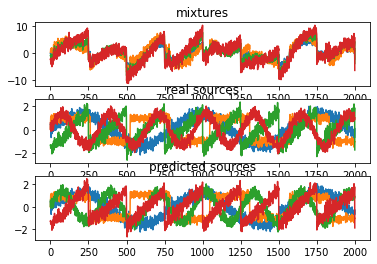

In [10]:
S = np.c_[s1, s2, s3, s4]
S += 0.2 * np.random.normal(size=S.shape)
S /= S.std(axis=0)
A = A = np.array(([[1, 1, 1, 1], [0.5, 2, 1.0, 2], [1.5, 1.0, 2.0, 1.5], [2, 1, 3, 1]]))
X = np.dot(S, A.T)
X = X.T
S_ = ica(X, iterations = 1000)

plot_mixture_sources_predictions(X, S.T, S_)

## Uso de ICA con sklearn

implementacion de sklearn para el algoritmo ICA

In [11]:
from sklearn.decomposition import FastICA

np.random.seed(0)
n_samples = 2000

time = np.linspace(0,8, n_samples)

s1 = np.sin(2 * time)  # sinusoidal
s2 = np.sign(np.sin(3 * time))  # square signal
s3 = signal.sawtooth(2 * np.pi * time)  # saw tooth signal
s4 = np.sin(5 * time)  # saw tooth signal

S = np.c_[s1, s2, s3, s4]
S += 0.2 * np.random.normal(size=S.shape)
S /= S.std(axis=0)
A = A = np.array(([[1, 1, 1, 1], [0.5, 2, 1.0, 2], [1.5, 1.0, 2.0, 1.5], [2, 1, 3, 1]]))
X = np.dot(S, A.T)

ica = FastICA(n_components=4)
S_ = ica.fit_transform(X)

c:\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


Grafico de resultados

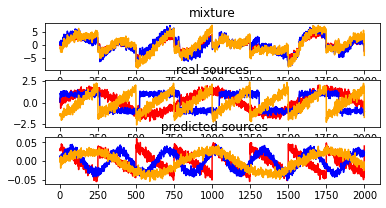

In [12]:
fig = plt.figure()

models = [X, S, S_]

names = ['mixture', 'real sources', ' predicted sources']
colors = ['red', 'blue', 'orange']

for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(4,1,i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)
